In [1]:
import numpy as np
import pandas as pd
from format_data import *
from preprocess import *
from plots import *

In [2]:
Db=pd.read_excel('table.xlsx')

In [6]:
preprocessed_Db = preprocess_supervised(Db, output_col=OutputColumn.yield_strength)

We retain only the rows with output values Yield strength / MPa, that is 47.215496% of the dataset


c:\Users\linab\Desktop\3A\ApprAuto\apprAuto-projet\preprocess.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Db[num_columns] = iterative_imputer.fit_transform(Db[num_columns])
c:\Users\linab\Desktop\3A\ApprAuto\apprAuto-projet\preprocess.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Db[cat_columns] = iterative_imputer.fit_transform(Db[cat_columns])
c:\Users\linab\Desktop\3A\ApprAuto\apprAuto-projet\preprocess.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

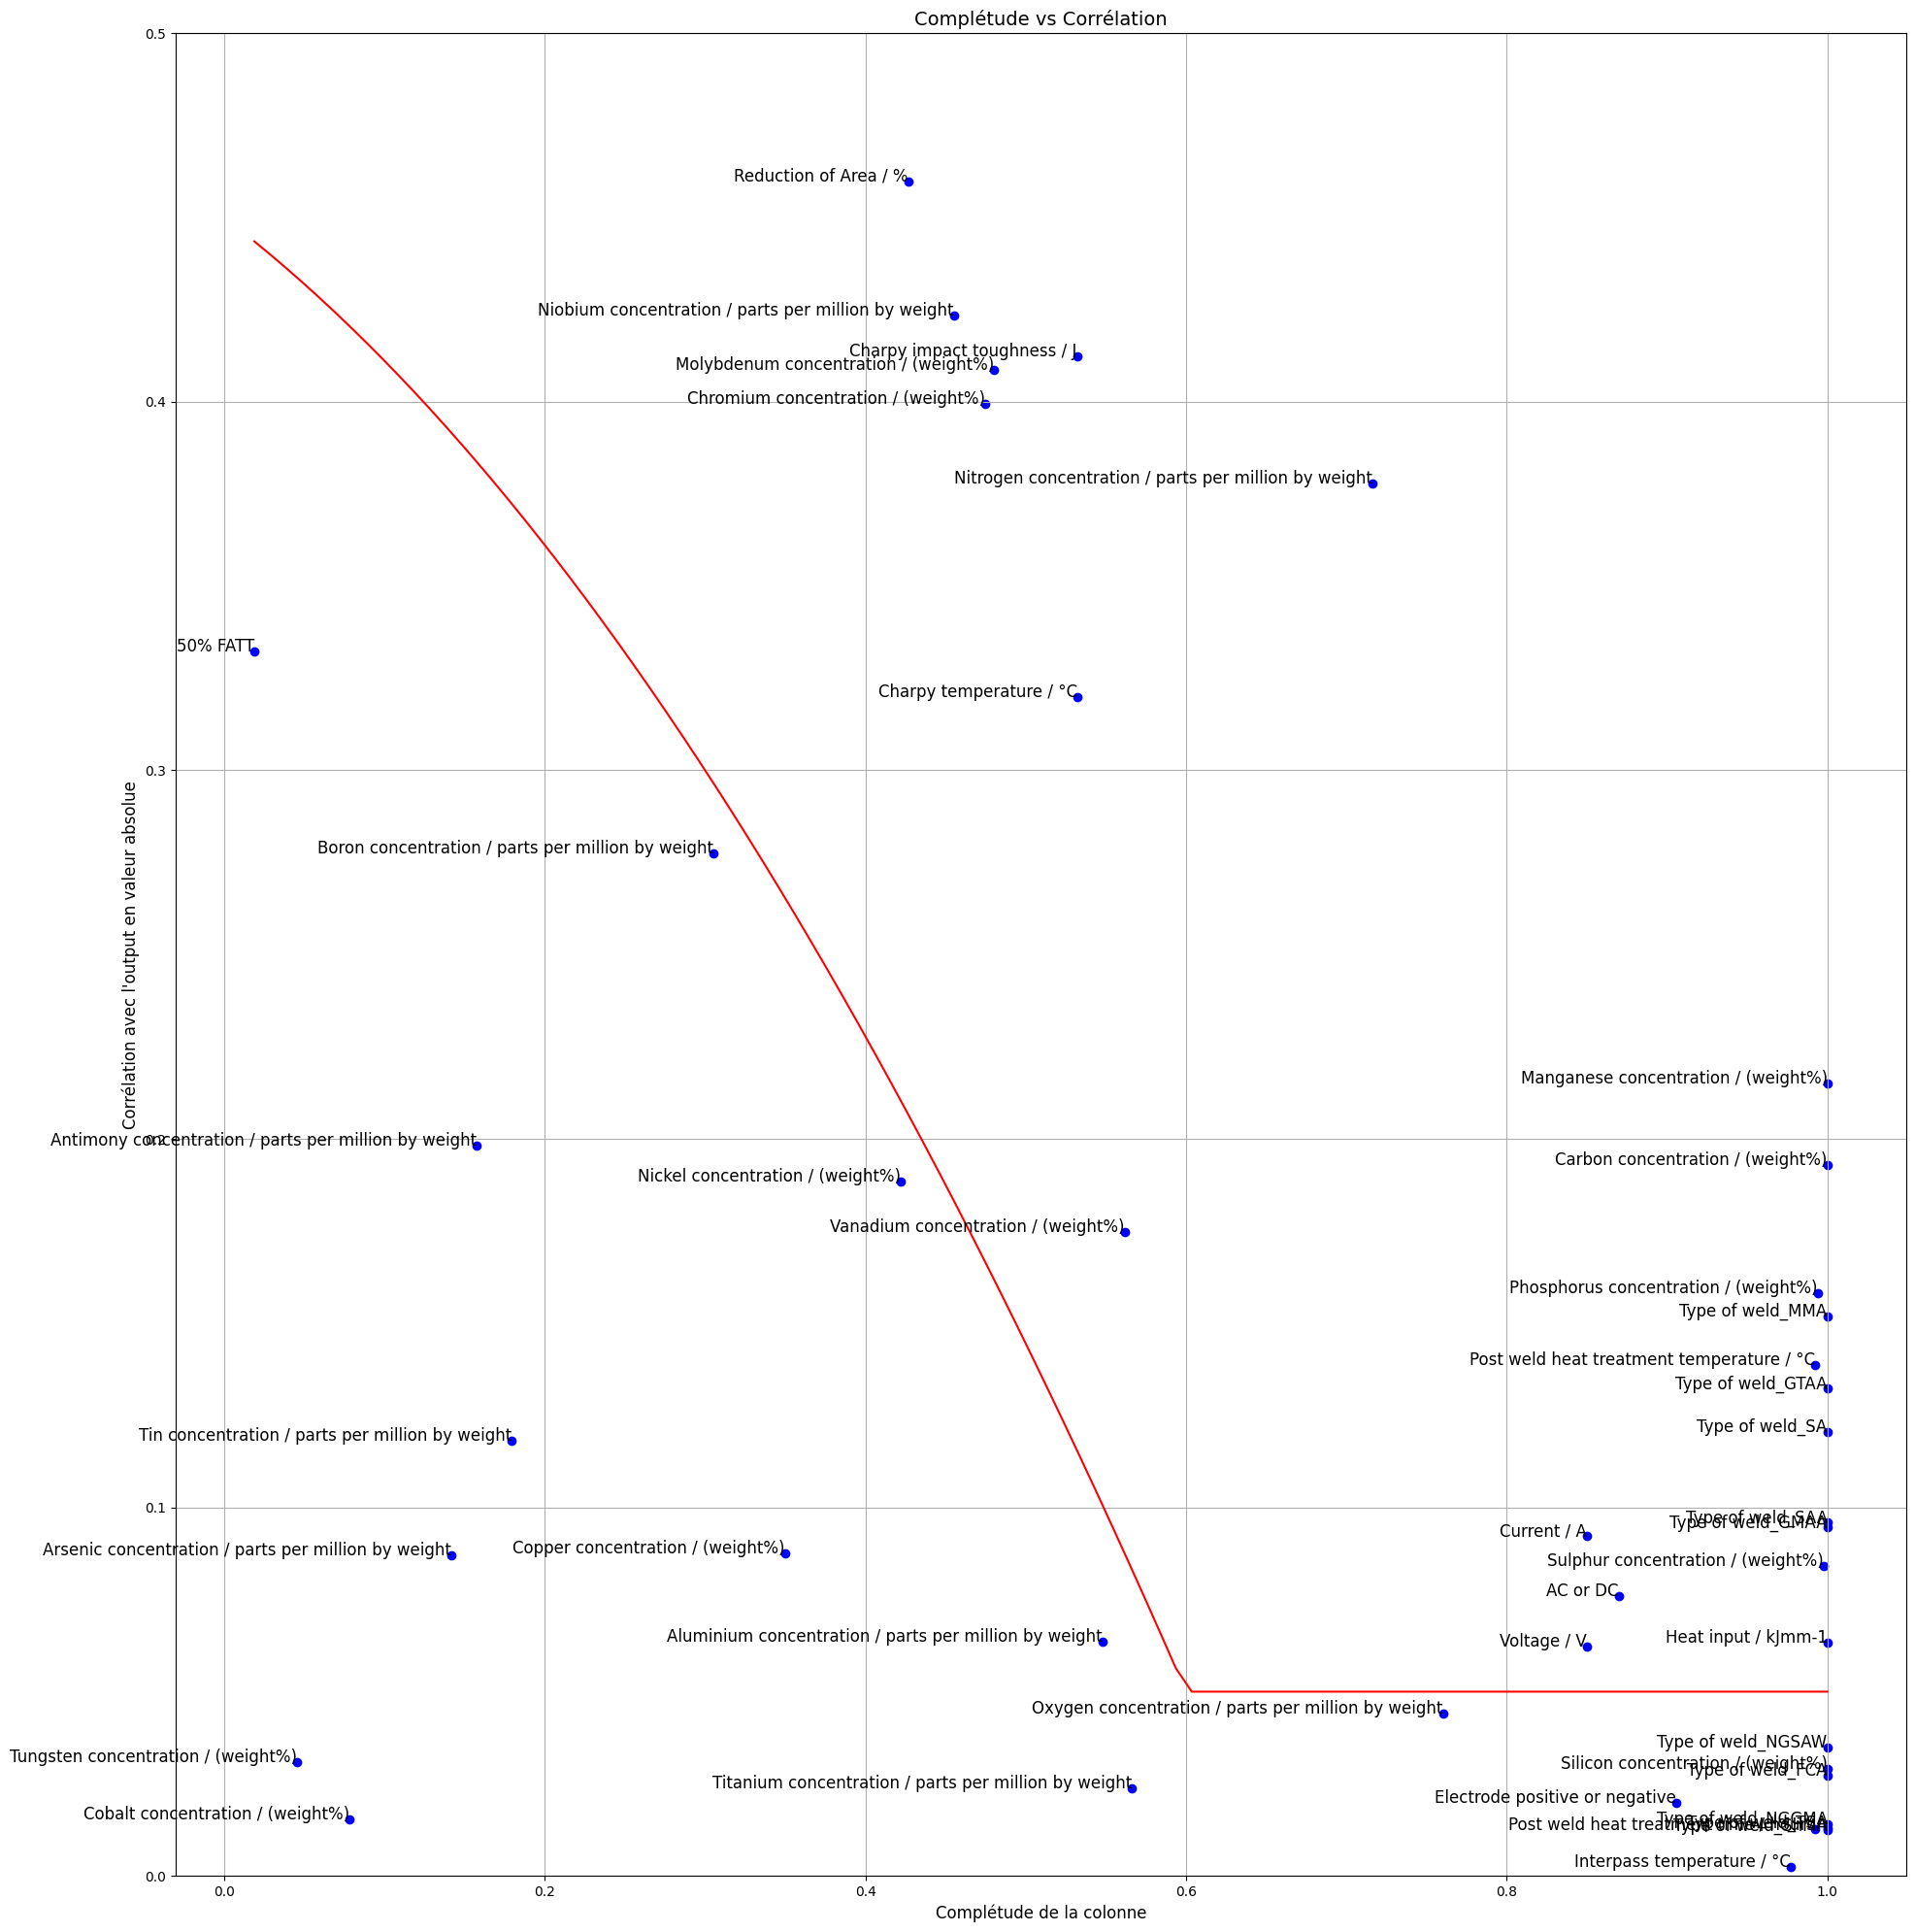

In [5]:
Db = Db.rename(columns={OutputColumn.yield_strength.value: 'output'})
features = list(set(Db.columns)-set(MECHANICAL_PROPERTIES))

# For the supervised approach we only keep the rows with an output
reduced_Db=Db.dropna(subset=['output'])
corr = get_corr(Db)
plot_completeness_vs_corr(corr)

In [8]:
y=preprocessed_Db['output']
X=preprocessed_Db.drop('output', axis=1)

In [11]:
pls2 = PLSRegression(n_components=5)
pls2.fit(X, y)
r2 = pls2.score(X, y)

print(f"R²: {r2}")
X_reduced = pls2.x_scores_
Y_pred = pls2.predict(X)


R²: 0.29009978873912057


Mean R² from Cross-Validation: 0.22


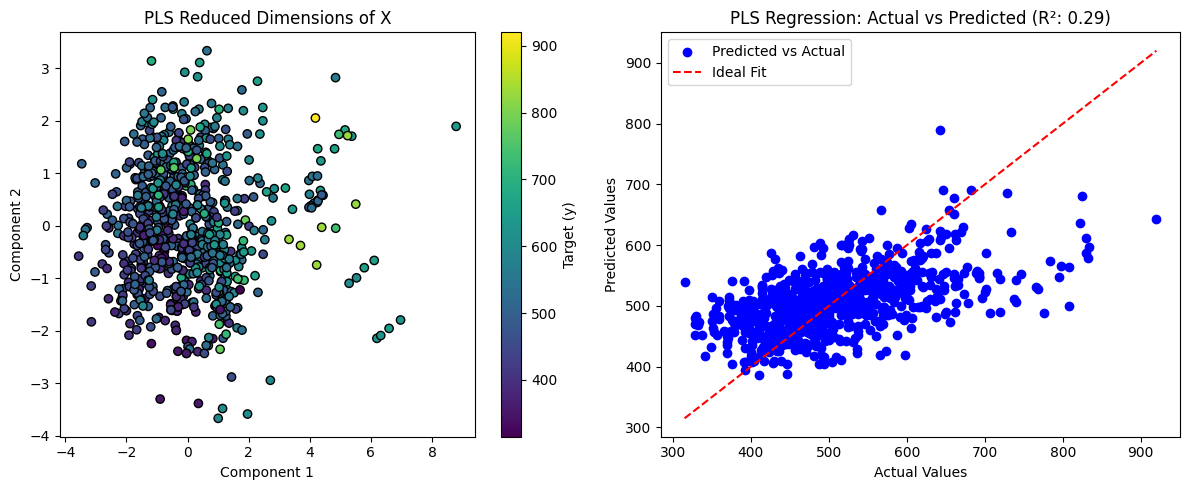

In [12]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.datasets import make_regression

# Initialize PLS Regression
n_components = 5
pls = PLSRegression(n_components=n_components)
n=np.shape(X)[0]
# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(pls, X, y, cv=cv, scoring='r2')
adjusted_r2 = r2_scores * (n-1)/(n-1-n_components)
# Fit the PLS model on the whole dataset
pls.fit(X, y)
# Predict values
Y_pred = pls.predict(X)
# Get reduced dimensions
X_reduced = pls.x_scores_
# Calculate the mean R² score
mean_r2 = np.mean(r2_scores)
print(f"Mean R² from Cross-Validation: {np.mean(adjusted_r2):.2f}")
plot_PLS(pls, X, y)

Plotting Fold 1/2


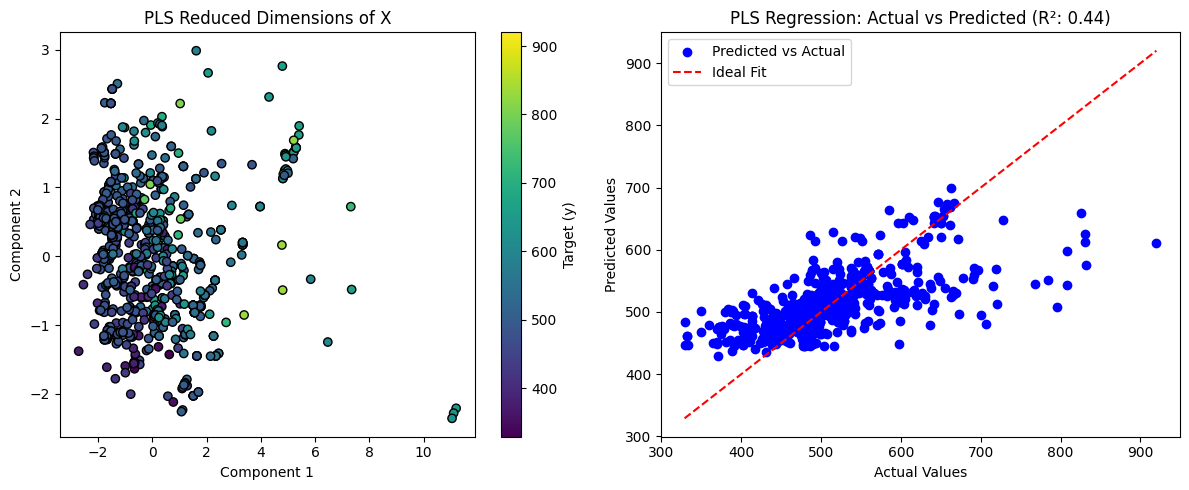

Plotting Fold 2/2


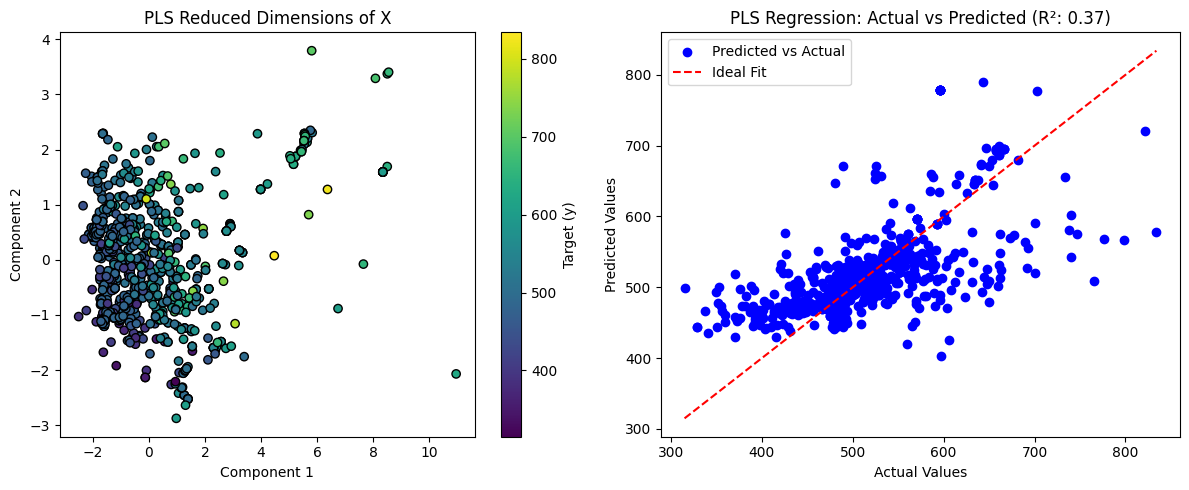

In [103]:
# Initialize K-Fold Cross-Validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize PLS Regression
    pls = PLSRegression(n_components=5)

    # Fit the model
    pls.fit(X_train, y_train)

    # Plot the results for the current fold
    print(f"Plotting Fold {fold + 1}/{n_splits}")
    plot_PLS(pls, X_test, y_test)